In [2]:
!pip install scikit-learn pandas matplotlib seaborn openpyxl

In [3]:
# Importaciones y configuración
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración de gráficos
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [4]:
# Carga de datos desde SQLite
db_path = '../data/airbnb.db'
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM listings", conn)
conn.close()

print(f"Dataset cargado: {df.shape[0]} registros, {df.shape[1]} columnas")
df.head()

Dataset cargado: 26401 registros, 77 columnas


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,categoria_precio
0,35797,https://www.airbnb.com/rooms/35797,20250625031918,2025-06-26 00:00:00,city scrape,Villa Dante,"Dentro de Villa un estudio de arte con futon, ...","Santa Fe Shopping Mall, Interlomas Park and th...",https://a0.muscache.com/pictures/f395ab78-1185...,153786,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Premium
1,44616,https://www.airbnb.com/rooms/44616,20250625031918,2025-07-01 00:00:00,city scrape,Condesa Haus,A new concept of hosting in mexico through a b...,None,https://a0.muscache.com/pictures/251410/ec75fe...,196253,...,2025-01-01 00:00:00,4.59,4.56,4.70,4.87,4.78,4.98,4.47,0.39,Premium
2,56074,https://www.airbnb.com/rooms/56074,20250625031918,2025-07-01 00:00:00,city scrape,Great space in historical San Rafael,This great apartment is located in one of the ...,Very traditional neighborhood with all service...,https://a0.muscache.com/pictures/3005118/60dac...,265650,...,2025-02-27 00:00:00,4.87,4.95,4.88,4.98,4.94,4.76,4.79,0.48,Medio
3,67703,https://www.airbnb.com/rooms/67703,20250625031918,2025-07-01 00:00:00,city scrape,"2 bedroom apt. deco bldg, Condesa","Comfortably furnished, sunny, 2 bedroom apt., ...",None,https://a0.muscache.com/pictures/3281720/6f078...,334451,...,2024-10-30 00:00:00,4.90,4.82,4.76,4.94,4.92,4.98,4.92,0.30,Alto
4,70644,https://www.airbnb.com/rooms/70644,20250625031918,2025-07-01 00:00:00,city scrape,Beautiful light Studio Coyoacan- full equipped !,COYOACAN designer studio quiet & safe! well eq...,Coyoacan is a beautiful neighborhood famous fo...,https://a0.muscache.com/pictures/f397d2da-d045...,212109,...,2024-12-28 00:00:00,4.92,4.91,4.96,4.96,4.98,4.96,4.92,0.81,Alto


=== INFORMACIÓN DEL DATASET ===
Registros totales: 26401

Estadísticas de precio:
count     23127.000000
mean       1989.292472
std       18500.684915
min          66.000000
25%         630.000000
50%        1039.000000
75%        1647.000000
max      900000.000000
Name: price, dtype: float64


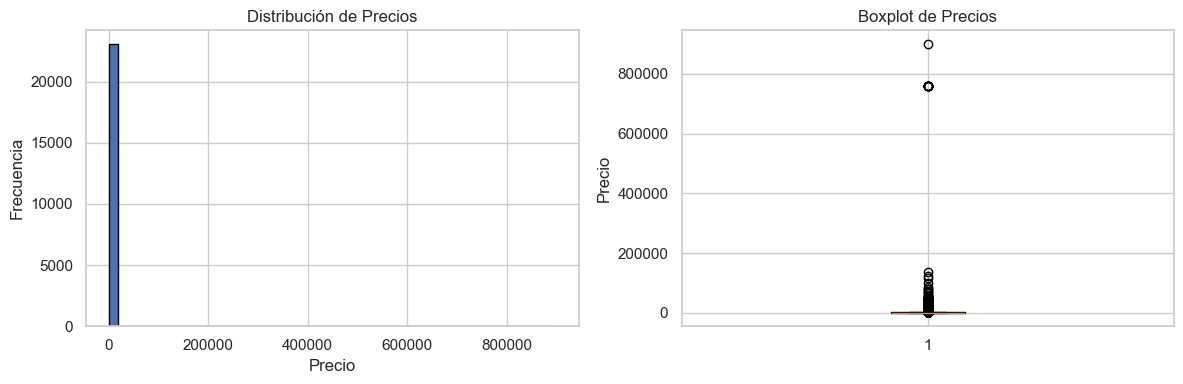


Precio mínimo: $66.00
Precio máximo: $900000.00
Precio promedio: $1989.29
Precio mediana: $1039.00


In [5]:
# Exploración inicial
print("=== INFORMACIÓN DEL DATASET ===")
print(f"Registros totales: {len(df)}")
print(f"\nEstadísticas de precio:")
print(df['price'].describe())

# Distribución de precios
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['price'].dropna(), bins=50, edgecolor='black')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución de Precios')

plt.subplot(1, 2, 2)
plt.boxplot(df['price'].dropna())
plt.ylabel('Precio')
plt.title('Boxplot de Precios')

plt.tight_layout()
plt.show()

print(f"\nPrecio mínimo: ${df['price'].min():.2f}")
print(f"Precio máximo: ${df['price'].max():.2f}")
print(f"Precio promedio: ${df['price'].mean():.2f}")
print(f"Precio mediana: ${df['price'].median():.2f}")

In [6]:
# Selección de features
features_numericas = [
    'accommodates', 
    'bedrooms', 
    'bathrooms',
    'availability_365',
    'number_of_reviews',
    'minimum_nights'
]

features_categoricas = [
    'property_type',
    'room_type',
    'neighbourhood_cleansed',
    'host_is_superhost'
]

target = 'price'

# Crear dataset de trabajo
columnas_necesarias = features_numericas + features_categoricas + [target]
df_trabajo = df[columnas_necesarias].copy()

print(f"Dataset de trabajo: {df_trabajo.shape}")
print(f"\nValores nulos por columna:")
print(df_trabajo.isnull().sum())

Dataset de trabajo: (26401, 11)

Valores nulos por columna:
accommodates                 0
bedrooms                   924
bathrooms                 3281
availability_365             0
number_of_reviews            0
minimum_nights               0
property_type                0
room_type                    0
neighbourhood_cleansed       0
host_is_superhost         1359
price                     3274
dtype: int64


In [7]:
# Limpieza de datos
print("\n=== LIMPIEZA DE DATOS ===")

# 1. Eliminar filas con nulos en columnas clave
df_trabajo = df_trabajo.dropna(subset=['price', 'bedrooms', 'bathrooms'])
print(f"Después de eliminar nulos: {len(df_trabajo)} registros")

# 2. Filtrar precios extremos (outliers)
percentil_99 = df_trabajo['price'].quantile(0.99)
df_trabajo = df_trabajo[df_trabajo['price'] <= percentil_99]
print(f"Después de filtrar outliers (precio <= ${percentil_99:.2f}): {len(df_trabajo)} registros")

# 3. Filtrar precios muy bajos (posibles errores)
df_trabajo = df_trabajo[df_trabajo['price'] >= 100]
print(f"Después de filtrar precios < $100: {len(df_trabajo)} registros")

# 4. Rellenar nulos restantes en numéricas con mediana
for col in features_numericas:
    if df_trabajo[col].isnull().sum() > 0:
        mediana = df_trabajo[col].median()
        df_trabajo[col].fillna(mediana, inplace=True)
        print(f"  - {col}: rellenado con mediana ({mediana})")

# 5. Rellenar nulos en categóricas con 'Unknown'
for col in features_categoricas:
    if df_trabajo[col].isnull().sum() > 0:
        df_trabajo[col].fillna('Unknown', inplace=True)
        print(f"  - {col}: rellenado con 'Unknown'")

print(f"\nDataset limpio final: {df_trabajo.shape}")


=== LIMPIEZA DE DATOS ===
Después de eliminar nulos: 23039 registros
Después de filtrar outliers (precio <= $10000.00): 22809 registros
Después de filtrar precios < $100: 22802 registros
  - host_is_superhost: rellenado con 'Unknown'

Dataset limpio final: (22802, 11)


In [8]:
# Encoding de variables categóricas
print("\n=== ENCODING DE VARIABLES CATEGÓRICAS ===")

# Agrupar property_type con pocas ocurrencias
property_counts = df_trabajo['property_type'].value_counts()
property_top = property_counts[property_counts >= 100].index
df_trabajo['property_type'] = df_trabajo['property_type'].apply(
    lambda x: x if x in property_top else 'Other'
)
print(f"property_type: {df_trabajo['property_type'].nunique()} categorías")

# Convertir host_is_superhost a numérico
df_trabajo['host_is_superhost'] = df_trabajo['host_is_superhost'].map(
    {True: 1, 'True': 1, 't': 1, 'VERDADERO': 1, 
     False: 0, 'False': 0, 'f': 0, 'FALSO': 0}
).fillna(0).astype(int)

# One-Hot Encoding para categóricas
df_encoded = pd.get_dummies(
    df_trabajo, 
    columns=['property_type', 'room_type', 'neighbourhood_cleansed'],
    drop_first=True
)

print(f"\nDataset después de encoding: {df_encoded.shape}")
print(f"Total de features: {df_encoded.shape[1] - 1}")


=== ENCODING DE VARIABLES CATEGÓRICAS ===
property_type: 16 categorías

Dataset después de encoding: (22802, 41)
Total de features: 40


In [9]:
# División en entrenamiento y prueba
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n=== DIVISIÓN DEL DATASET ===")
print(f"Entrenamiento: {X_train.shape[0]} registros")
print(f"Prueba: {X_test.shape[0]} registros")
print(f"Features: {X_train.shape[1]}")


=== DIVISIÓN DEL DATASET ===
Entrenamiento: 18241 registros
Prueba: 4561 registros
Features: 40


In [27]:
# Entrenamiento del modelo
print("\n=== ENTRENAMIENTO DEL MODELO ===")
print("Modelo: Random Forest Regressor")
print("Entrenando...")

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("✓ Modelo entrenado")

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
print("✓ Predicciones generadas")


=== ENTRENAMIENTO DEL MODELO ===
Modelo: Random Forest Regressor
Entrenando...
✓ Modelo entrenado
✓ Predicciones generadas


In [28]:
# Evaluación del modelo
print("\n=== MÉTRICAS DE EVALUACIÓN ===")

# Métricas en entrenamiento
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

print("\nEntrenamiento:")
print(f"  MAE:  ${mae_train:.2f}")
print(f"  RMSE: ${rmse_train:.2f}")
print(f"  R²:   {r2_train:.4f}")

# Métricas en prueba
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("\nPrueba:")
print(f"  MAE:  ${mae_test:.2f}")
print(f"  RMSE: ${rmse_test:.2f}")
print(f"  R²:   {r2_test:.4f}")

print("\n=== INTERPRETACIÓN ===")
print(f"El modelo explica el {r2_test*100:.1f}% de la variabilidad en los precios.")
print(f"En promedio, las predicciones se desvían ${mae_test:.2f} del precio real.")


=== MÉTRICAS DE EVALUACIÓN ===

Entrenamiento:
  MAE:  $300.57
  RMSE: $527.80
  R²:   0.8082

Prueba:
  MAE:  $485.18
  RMSE: $823.07
  R²:   0.5040

=== INTERPRETACIÓN ===
El modelo explica el 50.4% de la variabilidad en los precios.
En promedio, las predicciones se desvían $485.18 del precio real.


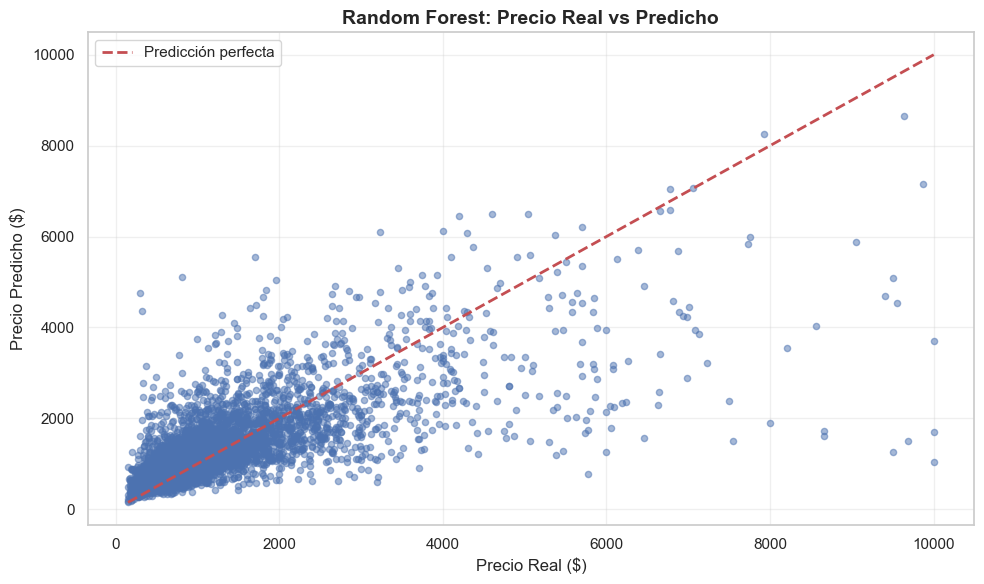

In [29]:
# Visualización: Real vs Predicho
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, s=20)

min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción perfecta')

plt.xlabel('Precio Real ($)', fontsize=12)
plt.ylabel('Precio Predicho ($)', fontsize=12)
plt.title('Random Forest: Precio Real vs Predicho', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


=== TOP 15 FEATURES MÁS IMPORTANTES ===
bedrooms                                 0.2084
bathrooms                                0.1672
availability_365                         0.1399
number_of_reviews                        0.1127
accommodates                             0.0849
room_type_Private room                   0.0701
minimum_nights                           0.0431
neighbourhood_cleansed_Cuauhtémoc        0.0311
neighbourhood_cleansed_Miguel Hidalgo    0.0236
host_is_superhost                        0.0215
property_type_Room in hotel              0.0146
property_type_Entire rental unit         0.0122
property_type_Other                      0.0099
room_type_Shared room                    0.0078
neighbourhood_cleansed_Benito Juárez     0.0075


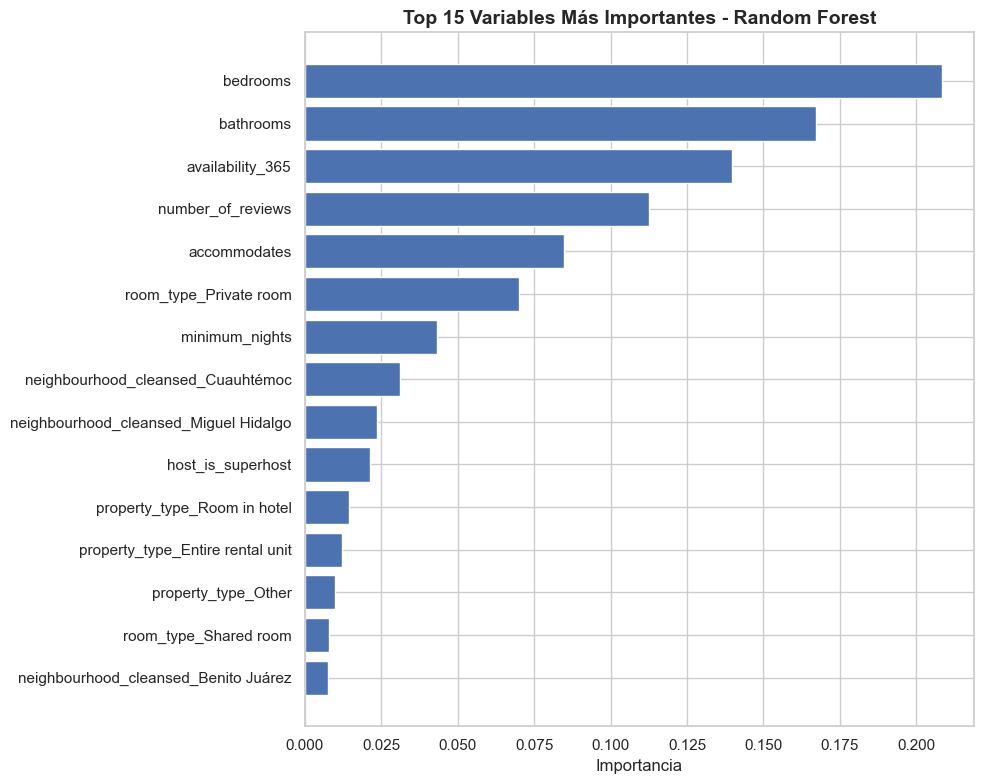

In [30]:
# Importancia de variables
importancias = pd.DataFrame({
    'feature': X.columns,
    'importancia': rf.feature_importances_
}).sort_values('importancia', ascending=False)

top_15 = importancias.head(15)

print("\n=== TOP 15 FEATURES MÁS IMPORTANTES ===")
for idx, row in top_15.iterrows():
    print(f"{row['feature']:40s} {row['importancia']:.4f}")

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_15)), top_15['importancia'])
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importancia', fontsize=12)
plt.title('Top 15 Variables Más Importantes - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

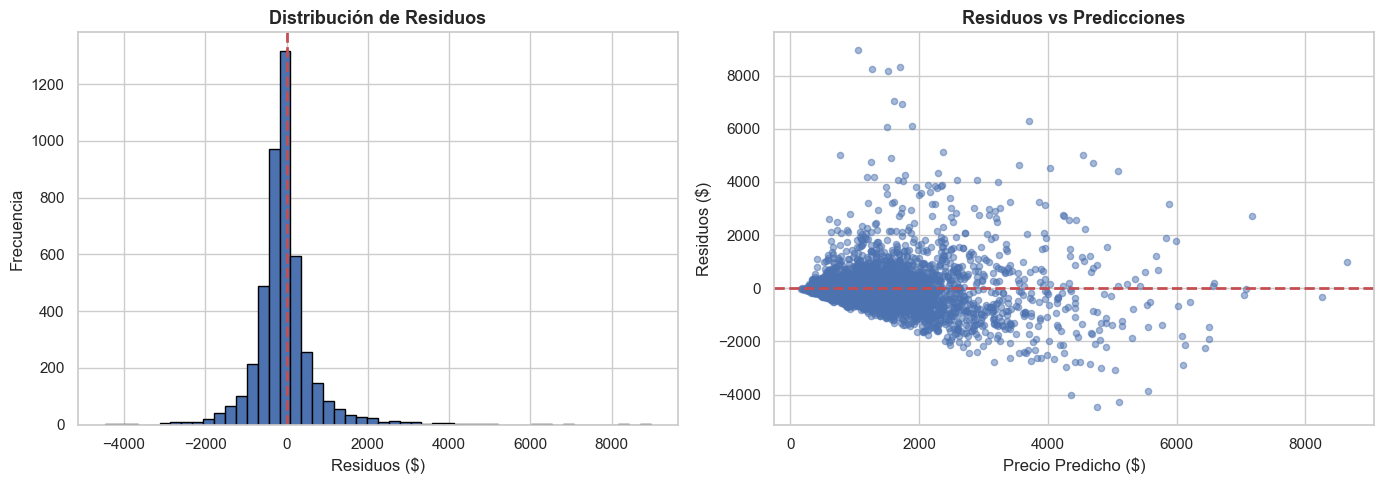


Media de residuos: $-46.87
Desviación estándar de residuos: $821.82


In [31]:
# Análisis de residuos
residuos = y_test - y_pred_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(residuos, bins=50, edgecolor='black')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residuos ($)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de Residuos', fontsize=13, fontweight='bold')

axes[1].scatter(y_pred_test, residuos, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Precio Predicho ($)', fontsize=12)
axes[1].set_ylabel('Residuos ($)', fontsize=12)
axes[1].set_title('Residuos vs Predicciones', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nMedia de residuos: ${residuos.mean():.2f}")
print(f"Desviación estándar de residuos: ${residuos.std():.2f}")